# *Init*

In [1]:
#@title Imports

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
# #@title Mount Data (For Google Colab)
# # Mount data drive

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# %cd /content/drive/MyDrive/CPSC4300-ADS-Project

# **Unhealthy Tree Detection in Segmented Drone Footage via Machine Learning**
**Clemson University | Fall 2023**<br>
**Authors:** Scott Logan, Lisa Umatoni, Mostafa Saberian, Ian McCall, Neil Kuehn


NOTES:

Look into adapting a pretrained model, such as VGG or Resnet, and retraining only the last few layers.

# **Project Goals!**

## The Mission
In this project, our goal is to analyze segmented drone footage to locate and annotate unhealthy trees found within the images using a Machine Learning model.


### To Do
- Finish Data Cleaning Methods
- Implement CNNs 2,3
- Try implementing 4: Look into adapting a pretrained model, such as VGG or Resnet, and retraining only the last few layers.

# **Data Summary**

The provided data set is a total of 60 images of trees, with 37 healthy trees and 23 sick tree images given. The main unit of analysis for determining whether a tree is sick or not is color. Healthy trees are greener and darker, whereas sick trees are yellowed and lighter. 

Note that dead areas, such as bare tree branches, are not counted as sick.

In [31]:
# Load All Images into Dataframe
def load_image(path):
    return_img = None
    try:
        return_img = image.load_img(path)
    except:
        print("Did not find file: " + path)
    
    return return_img

def get_full_path(name):
    return str("data/trees/" + name)

img_df = pd.read_json("data/img_metadata.json", dtype={'x': float, 'y': float, 'width': float, 'height': float})
img_df["file_name"] = img_df["file_name"].map(get_full_path)
img_df["image_data"] = img_df["file_name"].map(load_image)

Did not find file: data/trees/DJI_0038.JPG
Did not find file: data/trees/DJI_0039.JPG
Did not find file: data/trees/DJI_0040.JPG
Did not find file: data/trees/DJI_0041.JPG


In [34]:
img_df.dtypes

file_name          object
classification     object
x                 float64
y                 float64
width             float64
height            float64
image_data         object
dtype: object

# **Data Cleaning Strategies**

In a photograph, there is plenty of noise that may distract a Machine Learning Model from the data that is being represented. As such, it may be beneficial to perform data cleaning steps before training or predicting using the model.


We have decided to implement the following data cleaning steps, and test the model's performance using various combinations of these steps:

**Greyscale:** Normalize each pixel into a single grey value

**Isolate Hue:** Isolate the Red channel of each pixel
> Tree health is largely defined by yellowing, which in an RGB value is defined by an increase in the Red value. As such, we may be interested primarily in the Red channel, and may increase model accuracy by isolating or at least exaggerating the Red channel of images during processing.

**Omit Values Beyond Range of Interest:** Remove information likely to confuse the model
> Areas of images with red values that are too high are likely to be unrelated to tree data, so they should be omitted.



In [25]:
#@title Greyscale
def greyscale(input_img):
    output_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    return output_img

In [26]:
#@title Normalize Saturation and Value:
def normalize_saturation_value(input_img):
    # Convert the image from BGR to HSV color space
    hsv_image = image.rgb_to_hsv(input_img)
    #hsv_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2HSV)

    # Split the HSV image into separate channels
    h, s, v = cv2.split(hsv_image)

    # Normalize the saturation and value channels
    s = np.uint8(np.clip((s * 1.2), 0, 255))
    v = np.uint8(np.clip((v * 1.2), 0, 255))

    # Merge the normalized channels back into an HSV image
    hsv_image = cv2.merge([h, s, v])

    # Convert the HSV image back to BGR color space
    output_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    return output_image

In [27]:
#@title Isolate Hue:
def isolate_hue(input_img):
    
    # Exaggerate the red channel by decreasing blue and green by 80%
    output_img = input_img[:, :, :2] * 0.2

    return output_img

In [101]:
#@title Omit Unwanted Pixel Data Beyond Range of Interest
width = 225
height = 400
threshold_excess_red = 20
threshold_green_lower_bound = 20

def omit_unwanted_ranges(input_img,img_width = width, img_height = height):
    img_pixels = input_img.load()
    for i in range(img_height):
        for j in range(img_width):
            r,g,b = img_pixels[i,j]
            if (g < threshold_green_lower_bound):
                r = 0
                g = 0
            if (r > threshold_excess_red):
                r = 0
                g=0
            b = 0
            
    
    output_img = input_img
    return output_img

In [102]:
#@title Resize Images

def resize_img(input_img, targetwidth, targetheight):
    output_img = tf.image.resize(input_img, [targetwidth, targetheight])
    return output_img

# **Initial Model:** Convolutional Neural Network

We considered a number of different models for this project, choosing CNN as our initial model selection:
- **-> Convolutional Neural Network (CNN):** Suitable for classifying photos by visible features, which we plan to use by training the CNN to detect color patterns typical of sick trees.
- **Clustering Model:** May be useful to detect multiple instances of sick trees within an image, using elbow method to determine number of sick tree instances.
- **Classification Model:** Suitable for binary response values, which may be useful to classify healthy vs. sick.



## Model Implementations

A few different CNN implementations will be tested, primarily as an exploration of how CNNs work.

- Implementation 1: Brute-Force Classification Approach


- Implementation 2: 


- Implementation 3?: Repurpose trained model

### Implementation 1: Brute-Force Classification Approach

In our first implementation, the Brute-Force Classification Approach, all we will be doing is passing the healthy images and the sick images into a CNN and training it to categorize the images into healthy and sick. This approach is primarily to ensure that we can construct a functioning CNN model as a baseline before attempting more involved strategies.

- Training Data:
  - Cleaning Steps: Resize Images
- Model Architecture
  - Convolutional Layers: 
  - Two Pooling Layers: 
  - Two Dense Layers:
    - 128-unit Relu layer: Learn non-linear transformations of features to capture complex relationships between features.
    - 1-unit Sigmoid layer: Filters output into a single binary value: 0 for healthy (lacks sick features), 1 for sick (contains sick features)

In [103]:
# Load only images that we are interested in for this model
brute_force_df = img_df[img_df['classification'].isin(['sick', 'healthy'])]

In [104]:
# Define Data Cleaning step for Model
default_width, default_height = 225, 225
default_size = (default_width, default_height)
def clean_data(input_img, resize_width=default_width, resize_height=default_height):
    clean_img = input_img
    
    # Apply Data Cleaning Functions
    clean_img = resize_img(clean_img, resize_width, resize_height)
    
    output_img = clean_img
    return output_img

In [105]:
# Define Data Augmentation step for model
# Apply a number of random transformations on data set to increase the model's accuracy on more general data.
# Chosen transformations: rotations, width-shift, height-shift, shear, zoom, horizontal flips
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=clean_data
)

In [106]:
# Use tensorflow's Data Generator to create training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=(default_width, default_height),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=brute_force_df,
    x_col='file_name',
    y_col='classification',
    target_size=(default_width, default_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Build model with chosen layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Found 33 validated image filenames belonging to 2 classes.
Found 8 validated image filenames belonging to 2 classes.
Epoch 1/10
2/2 [==============================] - 5s 2s/step - loss: 1.6954 - accuracy: 0.0909 - val_loss: 3.1397e-04 - val_accuracy: 1.0000
Epoch 2/10
2/2 [==============================] - 4s 1s/step - loss: 1.1442 - accuracy: 0.8788 - val_loss: 0.6929 - val_accuracy: 0.3750
Epoch 3/10
2/2 [==============================] - 4s 3s/step - loss: 0.4070 - accuracy: 0.8485 - val_loss: 0.0543 - val_accuracy: 1.0000
Epoch 4/10
2/2 [==============================] - 4s 961ms/step - loss: 0.4368 - accuracy: 0.8788 - val_loss: 0.0245 - val_accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 4s 3s/step - loss: 0.6154 - accuracy: 0.8788 - val_loss: 0.0417 - val_accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 4s 1s/step - loss: 0.4713 - accuracy: 0.8788 - val_loss: 0.1923 - val_accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 4s 1

#### **Results and Discussion:** Brute-Force Classification Approach

In [107]:
# Get the number of validation steps
validation_steps = validation_generator.samples / validation_generator.batch_size

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator)

print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

1/1 [==============================] - 1s 521ms/step - loss: 0.0663 - accuracy: 1.0000
Validation loss: 0.06630673259496689
Validation accuracy: 1.0


With an end validation loss of 0.620 and a validation accuracy of 63.6%, the model appears to be fairly effective at classifying the images into healthy vs. sick.

However, I don't have much confidence in a result this good for the **Brute-Force** Classification Approach. During training, the model's accuracy was high from the start and remained about equally this high throughout training. To me, this is highly suspicious.

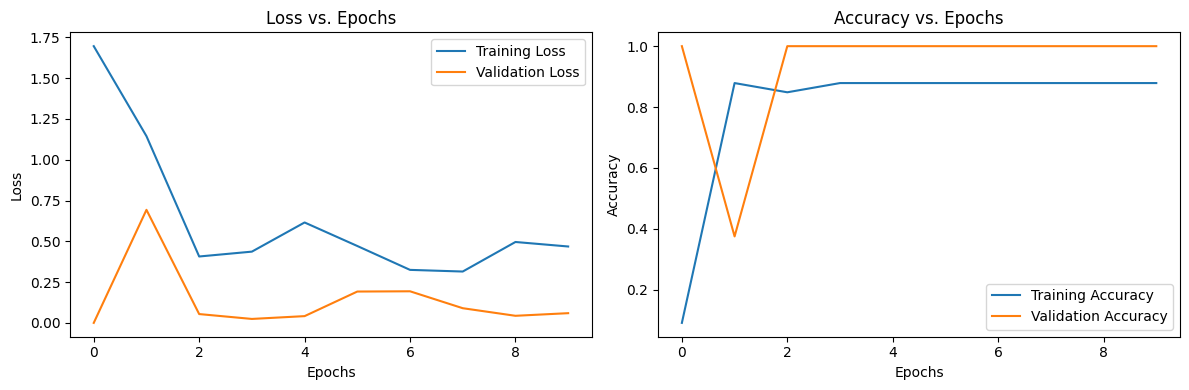

In [108]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot Loss and Accuracy throughout training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

I suspect that due to the limited sample size of our data (only 60 images is not much), there are trends in the images that correlate to the healthy vs sick image samples that are unrelated to the sick features of the trees. For example, visually inspecting the data shows that many of the healthy tree images contain the sky, and none of the sick images do. The healthy tree images also happen to be on average more exposed than sick images.

Because this is a classification approach, a visualization technique other than image labeling is not possible. As such, we'll need to modify our model to classify images as well as locate the sick features.

### Implementation 2: Localization Approach


Yeah pretty much this entire section is garbage so far. I tried setting up the model to output the classification as well as the bounding box of the feature, but kept running into errors, so I'm going to bed!

In [78]:
# Load only images that we are interested in for this model
localization_df = img_df[img_df['classification'].isin(['sick', 'healthy'])]

In [91]:
# Define Data Cleaning step for Model
default_width, default_height = 224, 224
default_size = (default_width, default_height)
def clean_data(input_img, resize_width=default_width, resize_height=default_height):
    clean_img = input_img
    
    # Apply Data Cleaning Functions
    clean_img = resize_img(clean_img, resize_width, resize_height)
    
    output_img = clean_img
    return output_img

In [96]:
# Define Data Augmentation step for model
# Apply a number of random transformations on data set to increase the model's accuracy on more general data.
# Chosen transformations: rotations, width-shift, height-shift, shear, zoom, horizontal flips

class MultiOutputDataGenerator(ImageDataGenerator):
    def flow_from_dataframe(self, dataframe, *args, **kwargs):
        dataframe = dataframe.copy()
        dataframe['multi_output_label'] = dataframe.apply(
            lambda row: [row['classification']] + [row['x'], row['y'], row['width'], row['height']], axis=1
        )
        return super().flow_from_dataframe(dataframe, y_col='multi_output_label', *args, **kwargs)
    
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x, batch_y = super()._get_batches_of_transformed_samples(index_array)

        # Split the multi_output_label into two separate tensors
        batch_y_class = np.asarray([label[0] for label in batch_y])
        batch_y_bbox = np.asarray([label[1:] for label in batch_y])

        # One-hot encode the class labels
        batch_y_class = tf.keras.utils.to_categorical(batch_y_class, num_classes=2)

        # Return the images and the two tensors for classification and bounding box coordinates
        return batch_x, [batch_y_class, batch_y_bbox]

    


In [97]:
# Define a new loss function, combining both the classification and localization loss functions

def combined_loss(y_true, y_pred):
    # Calculate classification loss
    class_true = y_true[:, :-4]
    class_pred = y_pred[:, :-4]
    class_loss = tf.keras.losses.categorical_crossentropy(class_true, class_pred)

    # Calculate bounding box loss
    bbox_true = y_true[:, -4:]
    bbox_pred = y_pred[:, -4:]
    bbox_loss = tf.keras.losses.mean_squared_error(bbox_true, bbox_pred)

    # Combine and return the losses
    return class_loss + bbox_loss

In [98]:
train_datagen = MultiOutputDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

validation_datagen = MultiOutputDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [99]:


# Build model with chosen layers
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Classification branch
classification_branch = tf.keras.layers.Dense(2, activation='softmax', name='classification_output')(model.layers[-2].output)

# Bounding box branch
bbox_branch = tf.keras.layers.Dense(4, name='bbox_output')(model.layers[-2].output)

# Combine the two branches
final_output = [classification_branch, bbox_branch]

# Build the final model
final_model = tf.keras.Model(inputs=model.input, outputs=final_output)



# Compile the model
model.compile(loss=combined_loss, optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


AttributeError: in user code:

    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\training.py", line 1055, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\training.py", line 1149, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\compile_utils.py", line 577, in update_state
        self.build(y_pred, y_true)
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\compile_utils.py", line 483, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\compile_utils.py", line 631, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\compile_utils.py", line 631, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\Users\theca\anaconda3\envs\Ch2_Env\lib\site-packages\keras\engine\compile_utils.py", line 652, in _get_metric_object
        y_t_rank = len(y_t.shape.as_list())

    AttributeError: 'tuple' object has no attribute 'shape'


#### **Results and Discussion:** Brute-Force Classification Approach

In [ ]:
# Get the number of validation steps
validation_steps = validation_generator.samples / validation_generator.batch_size

# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator)

print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

With an end validation loss of 0.620 and a validation accuracy of 63.6%, the model appears to be fairly effective at classifying the images into healthy vs. sick.

However, I don't have much confidence in a result this good for the **Brute-Force** Classification Approach. During training, the model's accuracy was high from the start and remained about equally this high throughout training. To me, this is highly suspicious.

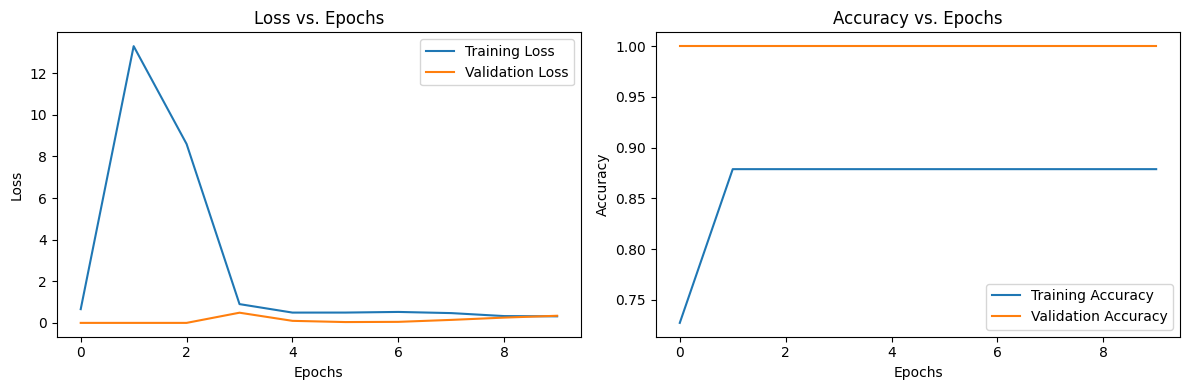

In [14]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot Loss and Accuracy throughout training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_loss, label='Training Loss')
ax1.plot(validation_loss, label='Validation Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracy, label='Training Accuracy')
ax2.plot(validation_accuracy, label='Validation Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()